## Source:
https://github.com/Vicam/Unsupervised_Anomaly_Detection/blob/master/Anomaly%20detection%2C%20different%20methods%20on%20a%20simple%20example.ipynb

## Goal: 
Search for anomaly in the ambient temperature in an office setting with unsupervised learning (no labeled data).
## Results:
No accurate score because there is no label but we check the result with visualisations.
## Methods:
**collective anomalies:** Cluster, isolation forest, one classifier svm, (nearest neighbour techniques)  
**contextual anomalies:** Cluster/categories + collective/point anomaly methods  
**point anomalies:** Gaussian (elliptic envelope)  
**ordered anomalies:** Markov chain, RNN, time series   
**collective ordered anomalies:** cluster+markov chain, other combination

solution -> pipelines of several methods and feature engineering
## References:
**Dataset:** https://www.kaggle.com/boltzmannbrain/nab  
**methods and categories of anomaly detection:** https://iwringer.wordpress.com/2015/11/17/anomaly-detection-concepts-and-techniques/  
**example of IoT use case and intelligent combination of methods:** https://journalofbigdata.springeropen.com/articles/10.1186/s40537-014-0011-y

In [133]:
# libraries
%matplotlib notebook

import pandas as pd
import numpy as np
#import scipy as sc
import custom_function as cf

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from fbprophet import Prophet

# 1 Data
## 1.1 Extract data
The dataset is from https://www.kaggle.com/boltzmannbrain/nab 
In realKnownCause/ambient_temperature_system_failure.csv

In [134]:
df = pd.read_csv("realKnownCause/realKnownCause/ambient_temperature_system_failure.csv")

## 1.2 Understand data

In [135]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
timestamp    7267 non-null object
value        7267 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.6+ KB
None


In [136]:
# check the timestamp format and frequence 
print(df['timestamp'].head(10))

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [137]:
# check the temperature mean
print(df['value'].mean())

71.2424327082882


In [138]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data is 
df.plot(x='timestamp', y='value')

<IPython.core.display.Javascript object>

## 1.3 Feature engineering
Extracting some useful features

In [139]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [140]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [141]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [142]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>

We can see that the temperature is more stable during daylight of business day.
# 2 Models
## 2.1 Cluster only
#### Use for collective anomalies (unordered). 

We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [143]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [144]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

<IPython.core.display.Javascript object>

In [145]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

4     679
0     596
6     587
3     585
10    567
9     563
1     517
14    512
12    489
2     397
7     394
5     354
8     350
13    340
11    337
Name: cluster, dtype: int64

In [146]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

<IPython.core.display.Javascript object>

In [147]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = cf.getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

/home/patryk_guenther/notebooks/inspiration/Unsupervised_Anomaly_Detection/custom_function.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  distance.set_value(i, np.linalg.norm(Xa-Xb))


In [148]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

<IPython.core.display.Javascript object>

In [149]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>

In [150]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

Cluster method detects the low temperature around the end of record as unusually low. It doesn't detect the highest temperature pic.
## 2.2 Categories + Gaussian
#### Use for contextual data and collective anomalies (unordered).  
We will separate data by (what we think of) important categories. Or we can separate data based on different cluster (method 2.3). Then we find outliers (gaussian repartition, unimodal) by categories independently.   

In [151]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

In [152]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

<IPython.core.display.Javascript object>

In [153]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

In [154]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [155]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

In [156]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>

In [157]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

Good detections of extreme values and context separation add some precision to the detection.
## 2.3 Cluster+Gaussian
Similar to 2.2 solution but with cluster to separate data in different group.

## 2.4 Markov chains
#### Use for  sequential anomalies (ordered)
We need discretize the data points in define states for markov chain. We will just take 'value' to define state for this example and define 5 levels of value (very low, low, average, high, very high)/(VL, L, A, H, VH).
Markov chain will calculate the probability of sequence like (VL, L, L, A, A, L, A). If the probability is very weak we consider the sequence as an anomaly.

In [158]:
# definition of the different state
x1 = (df['value'] <=18).astype(int)
x2= ((df['value'] > 18) & (df['value']<=21)).astype(int)
x3 = ((df['value'] > 21) & (df['value']<=24)).astype(int)
x4 = ((df['value'] > 24) & (df['value']<=27)).astype(int)
x5 = (df['value'] >27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5

# getting the anomaly labels for our dataset (evaluating sequence of 5 values and anomaly = less than 20% probable)
df_anomaly = cf.markovAnomaly(df_mm, 5, 0.20)
df_anomaly = pd.Series(df_anomaly)
print(df_anomaly.value_counts())

0    7147
1     120
dtype: int64


In [159]:
# add the data to the main 
df['anomaly24'] = df_anomaly

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>

In [160]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly24'] == 0, 'value']
b = df.loc[df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

Detect unusual sequence but not extreme value. More difficult to evaluate the relevance on this example. The sequence size (5) should be match with some interesting cycle.
## 2.5 Isolation Forest
#### Use for collective anomalies (unordered).
Simple, works well with different data repartition and efficient with high dimention data.

In [161]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7194
1      73
Name: anomaly25, dtype: int64


In [162]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>

In [163]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

## 2.6 One class SVM
#### Use for collective anomalies (unordered).
Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [164]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


In [165]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>

In [166]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

Give result similar to isolation forest but find some anomalies in average values. Difficult to know if it's relevant.
## 2.7 RNN
#### Use for  sequential anomalies (ordered)
RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.  
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [167]:
#select and standardize data
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [168]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [169]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json

In [170]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 5), units=50)`
  import sys
/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:480: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


compilation time : 0.01661539077758789


/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [171]:
# Train the model

model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=350,
    validation_split=0.1)


/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:480: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


Train on 5548 samples, validate on 617 samples
Epoch 1/350
5548/5548 [==============================] - 14s 3ms/step - loss: 0.5034 - val_loss: 0.5216
Epoch 2/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.1913 - val_loss: 0.3019
Epoch 3/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.1083 - val_loss: 0.2242
Epoch 4/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.1077 - val_loss: 0.2655
Epoch 5/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.1143 - val_loss: 0.2151
Epoch 6/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0916 - val_loss: 0.2030
Epoch 7/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0887 - val_loss: 0.2050
Epoch 8/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0949 - val_loss: 0.2102
Epoch 9/350
5548/5548 [==============================] - 14s 2ms/step - loss: 0.0963 - val_loss: 0.1803
Epoch 10/350
5548

5548/5548 [==============================] - 13s 2ms/step - loss: 0.0543 - val_loss: 0.0823
Epoch 79/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0512 - val_loss: 0.0790
Epoch 80/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0509 - val_loss: 0.0806
Epoch 81/350
5548/5548 [==============================] - 14s 2ms/step - loss: 0.0518 - val_loss: 0.0806
Epoch 82/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0564 - val_loss: 0.0823
Epoch 83/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0528 - val_loss: 0.0762
Epoch 84/350
5548/5548 [==============================] - 14s 2ms/step - loss: 0.0505 - val_loss: 0.0818
Epoch 85/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0492 - val_loss: 0.0876
Epoch 86/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0582 - val_loss: 0.1185
Epoch 87/350
5548/5548 [==============================] - 13s 2ms/st

5548/5548 [==============================] - 13s 2ms/step - loss: 0.0476 - val_loss: 0.0750
Epoch 156/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0457 - val_loss: 0.0698
Epoch 157/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0436 - val_loss: 0.0698
Epoch 158/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0440 - val_loss: 0.0708
Epoch 159/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0446 - val_loss: 0.0695
Epoch 160/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0457 - val_loss: 0.0744
Epoch 161/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0496 - val_loss: 0.0858
Epoch 162/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0504 - val_loss: 0.0783
Epoch 163/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0460 - val_loss: 0.0758
Epoch 164/350
5548/5548 [==============================] - 1

5548/5548 [==============================] - 13s 2ms/step - loss: 0.0425 - val_loss: 0.0790
Epoch 233/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0475 - val_loss: 0.0737
Epoch 234/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0440 - val_loss: 0.0791
Epoch 235/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0438 - val_loss: 0.0762
Epoch 236/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0433 - val_loss: 0.0758
Epoch 237/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0437 - val_loss: 0.0729
Epoch 238/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0438 - val_loss: 0.0733
Epoch 239/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0450 - val_loss: 0.0705
Epoch 240/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0444 - val_loss: 0.0697
Epoch 241/350
5548/5548 [==============================] - 1

5548/5548 [==============================] - 13s 2ms/step - loss: 0.0418 - val_loss: 0.0759
Epoch 310/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0413 - val_loss: 0.0750
Epoch 320/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0414 - val_loss: 0.0721
Epoch 321/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0410 - val_loss: 0.0753
Epoch 322/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0406 - val_loss: 0.0798
Epoch 323/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0415 - val_loss: 0.0791
Epoch 324/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0408 - val_loss: 0.0742
Epoch 325/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0412 - val_loss: 0.0770
Epoch 326/350
5548/5548 [==============================] - 13s 2ms/step - loss: 0.0430 - val_loss: 0.0749
Epoch 327/350
5548/5548 [==============================] - 1

In [172]:
# save the model because the training is long (1h30) and we don't want to do it every time

# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")


Saved model to disk


In [174]:
# load json and create model
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

/home/patryk_guenther/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:480: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


Loaded model from disk


In [175]:
# create the list of difference between prediction and test data
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

<IPython.core.display.Javascript object>


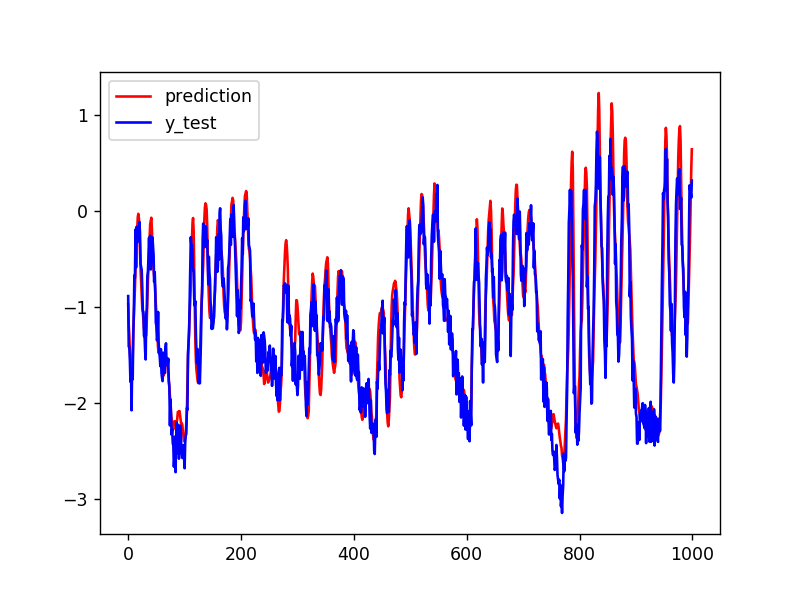

In [176]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [177]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
# # add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


<IPython.core.display.Javascript object>


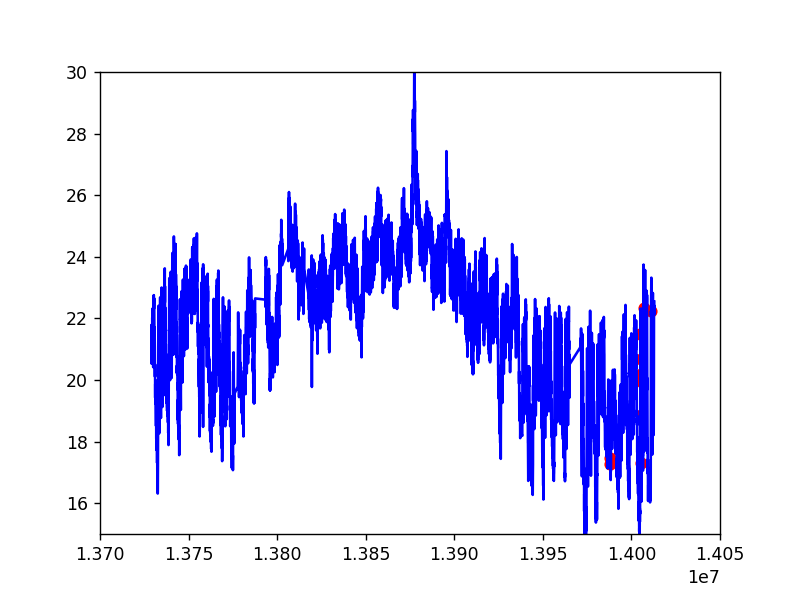

In [178]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.show()

<IPython.core.display.Javascript object>


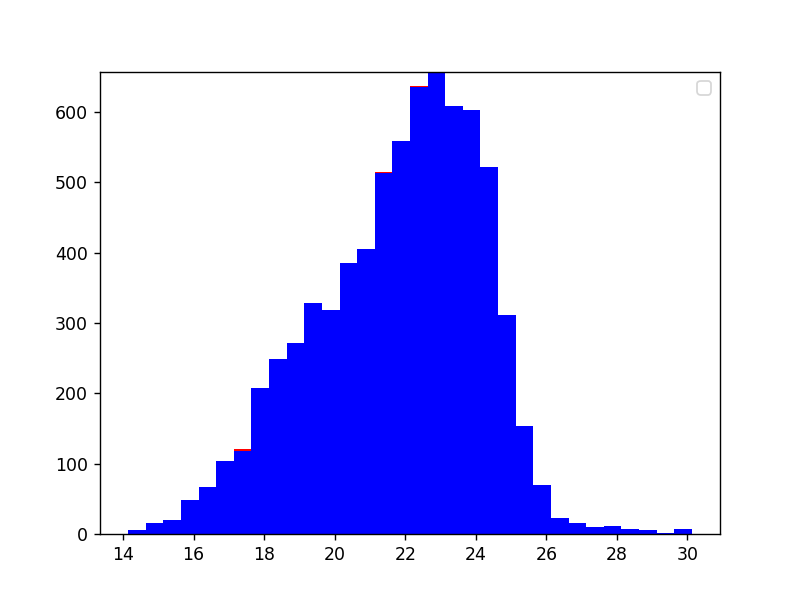

In [179]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

## 2.8 Collective and sequential anomalies (Ordered)
This class is most general and consider ordering as well as value combinations. We usually use combination of algorithm like cluster+markov model.

## 3 Result comparison

In [ ]:
# may be later, visualisations and anomaly matching between techniques

## 4 Conclusion
For this case, the contextual anomaly detection (categories+elliptique enveloppe) seem a good solution. 

general solution -> pipelines of several methods and feature engineering adapt to the use case